In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal
from tqdm import tqdm
import seaborn as sns
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, ComprehensiveFCParameters
import numpy as np

plt.rcParams['figure.figsize'] = (12, 8)

## <font color=orange>  Helper Functions </font>

In [2]:
def calculateBendingAngleAfterSpringback(df,
                                         threshold   = 1.0,
                                         section_dim = 200,
                                         median      = True):

      """Iterates backwards through dataframe in section_dim rows sections and 
      calculates the difference between the first and the last bending angle of 
      the section. If the difference is greater than threshold, the section is 
      considered as out of final beding angle range and the bending angle after 
      springback is calculated as the median of the after springback range.
      param: 
            df          : DataFrame
            threshold   : increasing rate of bedning angle in degrees/section_dim
            section_dim : section dimension to be considered while iterating.
            median      : True to use a median function on the section, that 
                        is considered as part of springback range.
      return: bending angle after springback
      """
      # drop the rows where at least one element is missing
      df.dropna(inplace=True)
      row = len(df) - 1
      while row > 0:
            if abs(df['Bending_Angle'].iloc[row] - df['Bending_Angle'].iloc[row - section_dim]) > threshold:
                  break
            row -= section_dim
      df_springback = df.iloc[row:]
      if median:
            return df_springback['Bending_Angle'].median()
      else:
            return df_springback['Bending_Angle'].mean()

## <font color=orange>  1. Data preprocessing </font>

In [3]:
# Constants
THRESHOLD_SPRINGBACK = 0.5 # in degrees/section_dim  

In [11]:
# create new pandas dataframe
df_ML = pd.DataFrame(columns=['Aluminum','Max_bending_angle', 'Thickness','Springback'])

In [12]:
# check wheter bending angle after spring back is calculated correctly
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/')
files = [f for f in files if f.endswith('.csv')]
springback = []
material = []
thickness = []
max_bending_angle = []
for file in tqdm(files):
    df = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/' + str(file), sep=';', decimal=',')
    # extract material from file name
    material_value = int(file.split('_')[0])
    material.append(material_value)
    # extract thickness from file name
    thickness_value = int(file.split('_')[1]) / 10
    thickness.append(thickness_value)
    # extract max bending angle from file name
    max_bending_angle.append(int(file.split('_')[2]))
    # calculate springback
    max_bending_angle_value = df['Bending_Angle'].max()
    bending_angle_after_springback = calculateBendingAngleAfterSpringback(df, threshold=THRESHOLD_SPRINGBACK, section_dim=200, median=True)
    springback_value = max_bending_angle_value - bending_angle_after_springback
    springback.append(springback_value)

100%|██████████| 363/363 [00:29<00:00, 12.37it/s]


In [ ]:
# check the difference between modells


In [13]:
# add the values from the lists to dataframe
df_ML['Thickness'] = thickness
df_ML['Springback'] = springback
df_ML['Max_bending_angle'] = max_bending_angle
# material column is categorical and in order to avoid spurious correlation 
# between features and prediction due to numerical values, it must be binary
df_ML['Aluminum'] = [1 if x == 1 else 0 for x in material]

In [14]:
df_ML

,Aluminum,Max_bending_angle,Thickness,Springback
0,1,30,1.0,3.363434
1,1,30,1.0,3.305664
2,1,30,1.0,3.207978
3,1,31,1.0,3.411530
4,1,31,1.0,3.379150
...,...,...,...,...
358,0,49,2.0,1.536682
359,0,49,2.0,1.892334
360,0,50,2.0,1.146362
361,0,50,2.0,1.199310


In [15]:
# export dataframe to csv
df_ML.to_csv("df_ML.csv", index=False)

In [16]:
# merge all dataframes into one dataframe for tsfresh
files = os.listdir('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten ML/')
files = [f for f in files if f.endswith('.csv')]
df_forces = pd.DataFrame(columns=['id','Time','Force1','Force2','Force3'])
id_ = 0
for file in tqdm(files):
    df_temp = pd.read_csv('1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten ML/' + str(file), sep=';', decimal=',')
    df_temp['Time'] = pd.to_datetime(df_temp['Time'])
    df_temp['id'] = id_
    df_forces = pd.concat([df_forces, df_temp[['id','Time','Force1','Force2','Force3']]], ignore_index=True)
    id_ += 1


100%|██████████| 363/363 [02:17<00:00,  2.63it/s]


In [17]:
# drop the rows where at least one element is missing
df_forces.dropna(inplace=True)
# change data type of columns
df_forces['id'] = df_forces['id'].astype(int)
df_forces['Force1'] = df_forces['Force1'].astype(float)
df_forces['Force2'] = df_forces['Force2'].astype(float)
df_forces['Force3'] = df_forces['Force3'].astype(float)

In [18]:
df_forces

,id,Time,Force1,Force2,Force3
0,0,2022-06-15 20:59:40.263000,0.557487,1.750093,2.703058
1,0,2022-06-15 20:59:40.268000,0.863571,2.281330,2.906976
2,0,2022-06-15 20:59:40.270000,0.748790,2.041008,2.805017
3,0,2022-06-15 20:59:40.271000,0.978353,2.192790,2.970700
4,0,2022-06-15 20:59:40.272000,0.723283,1.863930,2.728548
...,...,...,...,...,...
1600843,362,2022-06-15 15:24:26.434000,-33.173756,82.348546,149.705733
1600844,362,2022-06-15 15:24:26.435000,-33.033468,82.753298,149.731223
1600845,362,2022-06-15 15:24:26.436000,-33.224770,82.424437,149.680243
1600846,362,2022-06-15 15:24:26.438000,-32.969700,82.715352,149.731223


In [20]:
features_filtered_direct = extract_relevant_features(df_forces, 
                                                     df_ML["Springback"],
                                                     column_id='id', 
                                                     column_sort='Time',
                                                     default_fc_parameters=EfficientFCParameters(),
                                                     n_jobs=4)

Feature Extraction: 100%|██████████| 20/20 [13:25<00:00, 40.30s/it]


In [22]:
features_filtered_direct

,Force2__minimum,"Force2__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_6__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_7__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_4__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_12__w_10__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)",...,"Force1__fft_coefficient__attr_""real""__coeff_55","Force2__fft_coefficient__attr_""angle""__coeff_33",Force2__index_mass_quantile__q_0.8,Force2__binned_entropy__max_bins_10,Force3__number_peaks__n_3,"Force2__fft_coefficient__attr_""angle""__coeff_20","Force1__fft_coefficient__attr_""real""__coeff_90","Force1__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""",Force1__number_peaks__n_10,"Force2__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)"
0,1.750093,1.451504,1.743157,1.752501,1.943533,1.445136,1.955176,1.092355,2.451852,2.464834,...,-13.351059,91.859334,0.803414,1.038579,456.0,105.191867,-1.626990,-0.968686,151.0,-0.110292
1,1.191522,0.874183,1.115979,1.249061,1.346153,1.055572,1.310020,0.809274,0.939464,0.939664,...,14.524742,93.678329,0.817083,1.316679,457.0,103.983534,-1.054527,-0.942331,159.0,0.052599
2,2.668288,1.857089,2.098085,3.244066,3.308085,2.939685,3.064973,2.484132,4.313262,4.308169,...,-1.078185,97.386845,0.806557,1.317909,470.0,98.543445,-2.358291,-0.952035,143.0,-0.030954
3,1.899171,1.501413,1.806171,2.314457,2.430467,2.044972,2.338481,1.687575,2.504291,2.623092,...,4.947808,94.096132,0.804378,1.127125,563.0,97.390106,4.581242,-0.927426,174.0,-0.282100
4,1.674522,1.248992,1.581828,1.797758,1.951561,1.512780,1.922090,1.158426,1.937290,1.972448,...,8.418203,90.453033,0.798603,1.034074,535.0,102.956252,-4.385896,-0.943158,172.0,-0.148994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,4.209738,5.001641,6.663930,6.983379,5.873314,6.666059,4.816260,8.773197,8.864480,...,-8.526283,94.342010,0.802408,1.090710,527.0,108.760224,31.823563,-0.960898,166.0,-0.517686
359,8.132446,4.959477,5.980305,8.171648,8.633432,7.104662,8.284926,5.691524,8.832740,9.050344,...,-11.715103,99.057755,0.805635,0.880035,549.0,110.150926,-24.715808,-0.964603,158.0,-0.792721
360,15.566900,9.177159,11.290998,17.352550,17.776718,15.730784,16.678861,13.329690,22.429048,22.821072,...,-70.784044,98.362463,0.817653,1.331101,638.0,104.010363,23.758032,-0.971254,175.0,-0.194086
361,10.105525,7.184775,8.323663,12.188331,12.676070,10.819101,12.021411,8.909464,15.485918,15.749334,...,-10.088108,96.550197,0.823377,1.315002,630.0,101.480550,52.804788,-0.959097,182.0,-1.012418


In [23]:
# remove highly correlated features
print("Number of selected features from tsfresh : " + str(len(list(features_filtered_direct))) )
# Create correlation matrix
corr_matrix = features_filtered_direct.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
features_filtered_direct=features_filtered_direct.drop(features_filtered_direct[to_drop], axis=1)
print("Number of selected features after removing highly correlated features : " + str(len(list(features_filtered_direct))) )

Number of selected features from tsfresh : 1768
Number of selected features after removing highly correlated features : 440


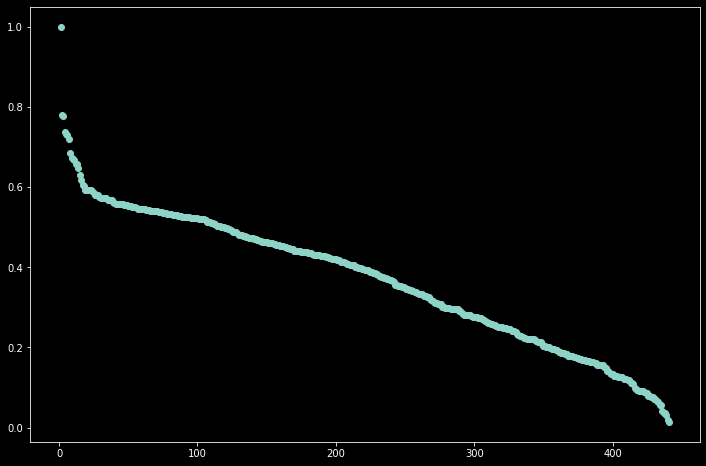

In [24]:
features_filtered_direct["Springback"]=df_ML["Springback"].values
corr_values=abs(features_filtered_direct.corrwith(features_filtered_direct["Springback"])).sort_values(ascending=False)
plt.scatter(np.linspace(1,len(corr_values),len(corr_values)),corr_values)

In [25]:
corr_values=abs(features_filtered_direct.corrwith(features_filtered_direct["Springback"]))
# Find index of feature columns which correlate with the scrap rate with a value greater than 0.25
to_keep = [column for column in corr_values.index if corr_values[column] > 0.25]
features_filtered_direct=features_filtered_direct[to_keep]

In [26]:
features_filtered_direct

,Force2__minimum,Force1__absolute_maximum,Force3__ar_coefficient__coeff_0__k_10,"Force1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","Force1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force3__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Force1__friedrich_coefficients__coeff_0__m_3__r_30,"Force3__fft_aggregated__aggtype_""skew""","Force3__fft_coefficient__attr_""real""__coeff_7",...,Force1__mean_second_derivative_central,Force2__energy_ratio_by_chunks__num_segments_10__segment_focus_4,"Force2__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0",Force2__symmetry_looking__r_0.05,Force2__partial_autocorrelation__lag_4,Force2__ratio_beyond_r_sigma__r_3,"Force2__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","Force2__fft_coefficient__attr_""angle""__coeff_25","Force2__fft_coefficient__attr_""angle""__coeff_33",Springback
0,1.750093,5.168843,0.171159,0.000304,-0.000257,-0.002748,-2.793987,-2.943393e-03,2.586472,-695.039740,...,-0.000044,0.111850,0.224118,1.0,-0.019961,0.033342,-0.498031,95.995683,91.859334,3.363434
1,1.191522,5.415735,0.196123,0.000396,-0.000347,-0.003185,-3.868151,-1.176885e-03,2.575715,-683.485735,...,0.000017,0.103157,0.231152,1.0,-0.000341,0.023390,-0.432703,97.448901,93.678329,3.305664
2,2.668288,4.596850,0.153288,0.000376,-0.000377,-0.002538,-3.846174,-1.672138e-03,2.587518,-525.318309,...,-0.000113,0.115441,0.257398,0.0,-0.001502,0.027049,-0.479264,89.853971,97.386845,3.207978
3,1.899171,4.074218,0.153036,0.000295,-0.000345,-0.001791,-2.917858,-4.459243e-03,2.480422,-566.152624,...,-0.000028,0.108011,0.253068,1.0,0.000532,0.034101,-0.301564,97.211872,94.096132,3.411530
4,1.674522,3.794187,0.161958,0.000285,-0.000336,-0.001614,-3.382060,-4.828719e-03,2.509571,-524.237506,...,-0.000054,0.106654,0.200334,1.0,-0.026071,0.028427,-0.247106,97.848257,90.453033,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,21.434775,0.420278,0.000929,-0.006059,-0.023401,-9.743080,-1.084730e-05,2.818395,-2559.564212,...,-0.000041,0.107605,0.217628,1.0,0.010478,0.023436,-0.331379,99.035628,94.342010,1.536682
359,8.132446,19.131389,0.450033,0.000818,-0.008879,-0.030855,-15.084403,-1.255388e-05,2.780082,-2477.162119,...,-0.000046,0.110616,0.215165,1.0,0.000147,0.021792,-0.288334,104.468524,99.057755,1.892334
360,15.566900,28.216828,0.513256,0.001054,-0.005805,-0.027102,-14.371245,-1.233977e-06,2.893607,-3322.134222,...,-0.000041,0.109326,0.270840,0.0,0.010531,0.018779,-0.327032,103.225444,98.362463,1.146362
361,10.105525,32.405360,0.491699,0.001474,-0.006045,-0.025580,-11.322496,-8.342889e-07,2.828337,-4270.867840,...,-0.000179,0.111566,0.257913,0.0,0.004031,0.022378,-0.327292,99.701283,96.550197,1.199310


In [27]:
# delete Springback column from df_ML
features_filtered_direct.drop(columns=['Springback'], inplace=True)
# join df_ML and features_filtered_direct
df_total = features_filtered_direct.join(df_ML, how='inner')

In [28]:
df_total

,Force2__minimum,Force1__absolute_maximum,Force3__ar_coefficient__coeff_0__k_10,"Force1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","Force1__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force3__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)",Force1__friedrich_coefficients__coeff_0__m_3__r_30,"Force3__fft_aggregated__aggtype_""skew""","Force3__fft_coefficient__attr_""real""__coeff_7",...,Force2__symmetry_looking__r_0.05,Force2__partial_autocorrelation__lag_4,Force2__ratio_beyond_r_sigma__r_3,"Force2__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""","Force2__fft_coefficient__attr_""angle""__coeff_25","Force2__fft_coefficient__attr_""angle""__coeff_33",Aluminum,Max_bending_angle,Thickness,Springback
0,1.750093,5.168843,0.171159,0.000304,-0.000257,-0.002748,-2.793987,-2.943393e-03,2.586472,-695.039740,...,1.0,-0.019961,0.033342,-0.498031,95.995683,91.859334,1,30,1.0,3.363434
1,1.191522,5.415735,0.196123,0.000396,-0.000347,-0.003185,-3.868151,-1.176885e-03,2.575715,-683.485735,...,1.0,-0.000341,0.023390,-0.432703,97.448901,93.678329,1,30,1.0,3.305664
2,2.668288,4.596850,0.153288,0.000376,-0.000377,-0.002538,-3.846174,-1.672138e-03,2.587518,-525.318309,...,0.0,-0.001502,0.027049,-0.479264,89.853971,97.386845,1,30,1.0,3.207978
3,1.899171,4.074218,0.153036,0.000295,-0.000345,-0.001791,-2.917858,-4.459243e-03,2.480422,-566.152624,...,1.0,0.000532,0.034101,-0.301564,97.211872,94.096132,1,31,1.0,3.411530
4,1.674522,3.794187,0.161958,0.000285,-0.000336,-0.001614,-3.382060,-4.828719e-03,2.509571,-524.237506,...,1.0,-0.026071,0.028427,-0.247106,97.848257,90.453033,1,31,1.0,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,21.434775,0.420278,0.000929,-0.006059,-0.023401,-9.743080,-1.084730e-05,2.818395,-2559.564212,...,1.0,0.010478,0.023436,-0.331379,99.035628,94.342010,0,49,2.0,1.536682
359,8.132446,19.131389,0.450033,0.000818,-0.008879,-0.030855,-15.084403,-1.255388e-05,2.780082,-2477.162119,...,1.0,0.000147,0.021792,-0.288334,104.468524,99.057755,0,49,2.0,1.892334
360,15.566900,28.216828,0.513256,0.001054,-0.005805,-0.027102,-14.371245,-1.233977e-06,2.893607,-3322.134222,...,0.0,0.010531,0.018779,-0.327032,103.225444,98.362463,0,50,2.0,1.146362
361,10.105525,32.405360,0.491699,0.001474,-0.006045,-0.025580,-11.322496,-8.342889e-07,2.828337,-4270.867840,...,0.0,0.004031,0.022378,-0.327292,99.701283,96.550197,0,50,2.0,1.199310


In [44]:
print(df_total.corr(method='pearson')['Springback']['Max_bending_angle'])
print(df_total.corr(method='kendall')['Springback']['Max_bending_angle'])
print(df_total.corr(method='spearman')['Springback']['Max_bending_angle'])

0.12986571650077655
0.10062492722498992
0.14160962427648593


In [38]:
# select only features with correlation higher than 0.5
corr_values=abs(df_total.corrwith(df_total["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.60]
df_corr=df_total[to_keep]

In [39]:
df_corr

,Force2__minimum,Force1__absolute_maximum,Force3__ar_coefficient__coeff_0__k_10,"Force1__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""min""","Force3__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","Force2__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)","Force3__fft_aggregated__aggtype_""skew""","Force3__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Force2__cwt_coefficients__coeff_0__w_5__widths_(2, 5, 10, 20)","Force1__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""","Force1__fft_aggregated__aggtype_""kurtosis""","Force2__fft_aggregated__aggtype_""skew""",Force1__partial_autocorrelation__lag_2,Force1__fourier_entropy__bins_100,Force3__ar_coefficient__coeff_1__k_10,"Force2__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""","Force1__augmented_dickey_fuller__attr_""usedlag""__autolag_""AIC""",Thickness,Springback
0,1.750093,5.168843,0.171159,0.000304,-0.002748,-2.793987,2.586472,-0.319868,-0.025378,-0.016329,4.499406,2.308401,0.518591,0.876610,0.108123,11.0,17.0,1.0,3.363434
1,1.191522,5.415735,0.196123,0.000396,-0.003185,-3.868151,2.575715,-0.821986,-0.203728,0.457610,3.928409,1.912661,0.527570,0.367826,0.122385,28.0,26.0,1.0,3.305664
2,2.668288,4.596850,0.153288,0.000376,-0.002538,-3.846174,2.587518,-0.578264,-0.698118,-0.104749,4.171451,2.138163,0.525213,0.748734,0.142026,12.0,18.0,1.0,3.207978
3,1.899171,4.074218,0.153036,0.000295,-0.001791,-2.917858,2.480422,-0.389926,-0.127015,-0.185395,3.768484,1.965528,0.530569,1.039674,0.048453,16.0,17.0,1.0,3.411530
4,1.674522,3.794187,0.161958,0.000285,-0.001614,-3.382060,2.509571,-0.486376,-0.105928,-0.468824,3.944952,2.074042,0.515572,1.094297,0.055610,20.0,17.0,1.0,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.474426,21.434775,0.420278,0.000929,-0.023401,-9.743080,2.818395,-1.322245,-0.909480,-1.239666,7.739451,2.789704,0.650556,0.136002,0.391094,32.0,32.0,2.0,1.536682
359,8.132446,19.131389,0.450033,0.000818,-0.030855,-15.084403,2.780082,-1.376086,-1.037407,-1.781659,7.848263,2.824668,0.582745,0.136002,0.403413,32.0,32.0,2.0,1.892334
360,15.566900,28.216828,0.513256,0.001054,-0.027102,-14.371245,2.893607,-1.930854,-1.989883,-2.939427,8.105587,2.962559,0.201584,0.181214,0.397424,31.0,33.0,2.0,1.146362
361,10.105525,32.405360,0.491699,0.001474,-0.025580,-11.322496,2.828337,-2.184927,-1.345940,-2.229959,8.946828,2.865098,0.189527,0.136002,0.377792,33.0,33.0,2.0,1.199310


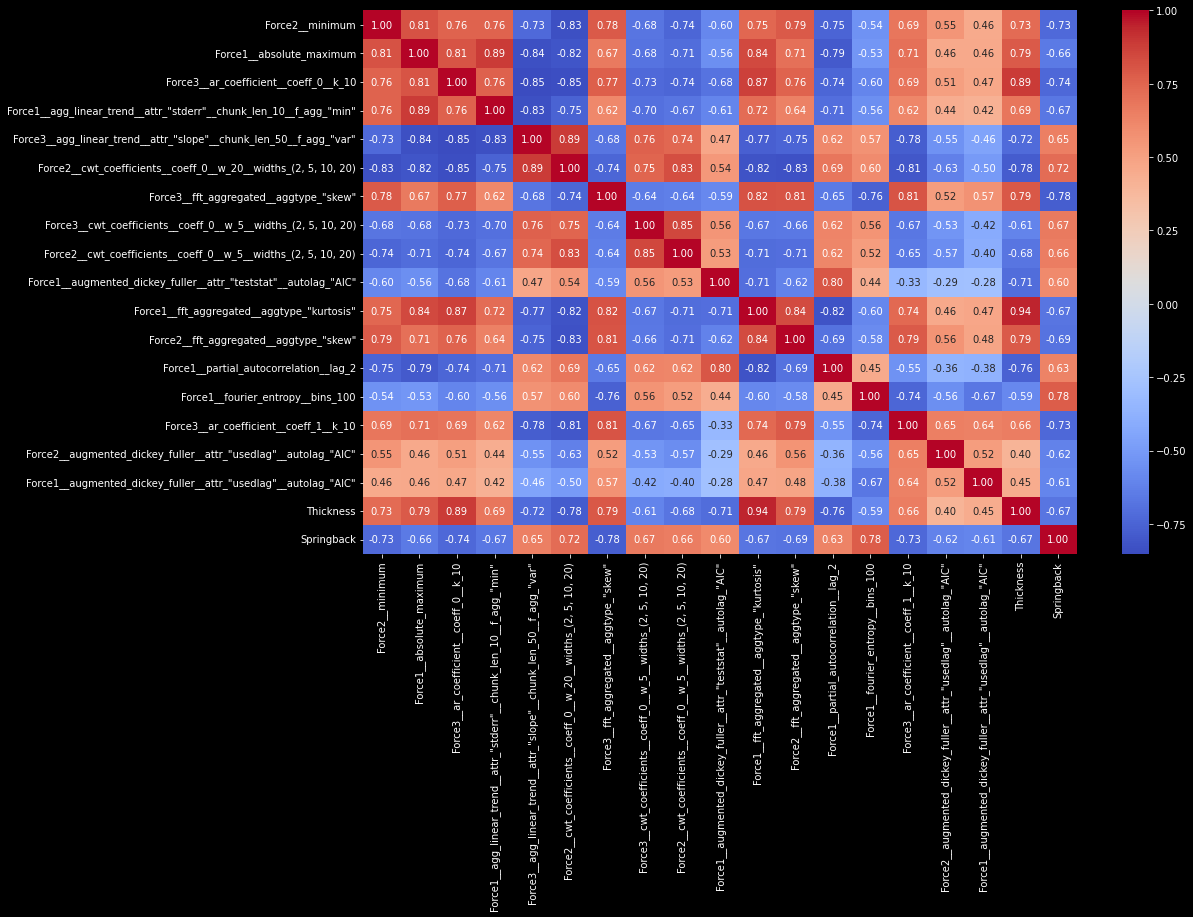

In [31]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_corr.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

## <font color=orange>  2. Model Training </font>

In [53]:
X = df_corr.iloc[:, :-1].values
y = df_corr.iloc[:, -1].values

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [55]:
parameters = {
    'bootstrap': [True],
    'max_depth': [50, 80],
    'max_features': [2, 5],
    'min_samples_leaf': [4, 6],
    'min_samples_split': [10, 14],
    'n_estimators': [100,300]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf,
                           param_grid = parameters,
                           cv = 5, # cross validation split
                           n_jobs = -1, 
                           scoring = 'r2',
                           verbose=1)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
best_estimator=grid_search.best_estimator_
print("Best score: {:.2f}".format(best_score))
print("Best Parameters: ", best_parameters)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best score: 0.86
Best Parameters:  {'bootstrap': True, 'max_depth': 80, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [56]:
rf = RandomForestRegressor( **best_parameters,
                           oob_score = True,
                           random_state = 0,
                           n_jobs = -1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

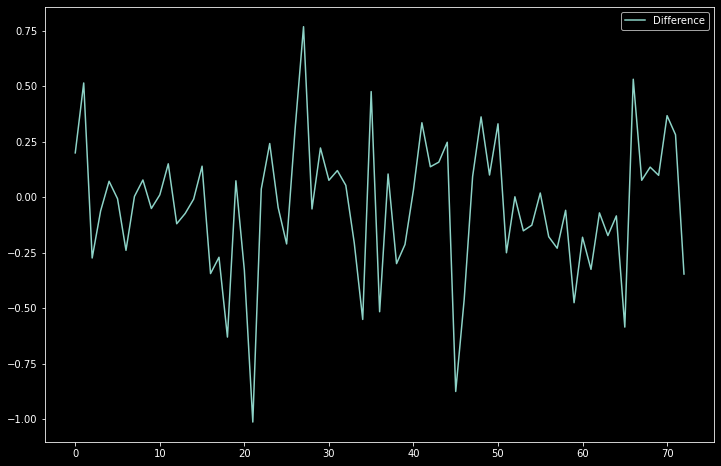

In [66]:
# difference over time
plt.plot(y_pred_rf - y_test, label = 'Difference')
plt.legend()
plt.show()

<AxesSubplot:ylabel='Count'>

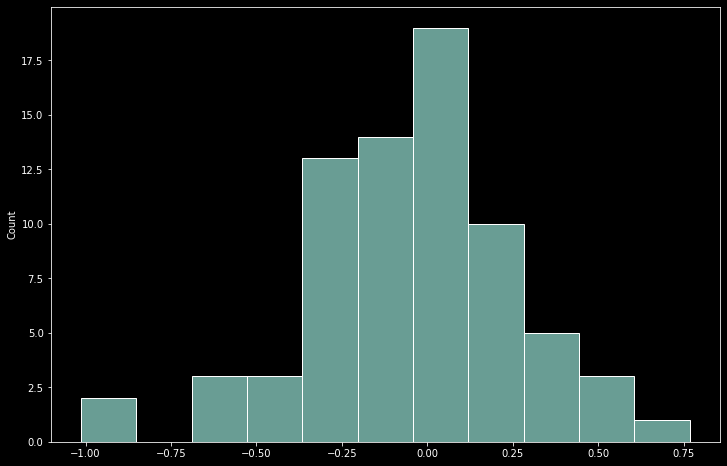

In [67]:
sns.histplot(y_pred_rf - y_test, label = 'Difference')

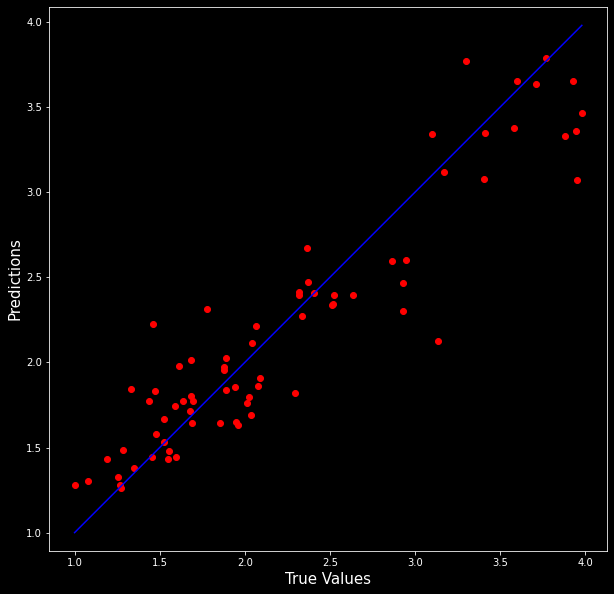

In [57]:
# preadictions over true values
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred_rf, c = 'red')

p1 = max(max(y_pred_rf), max(y_test))
p2 = min(min(y_pred_rf), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()